# Lineage graphs

In [1]:
import tskit
import tszip

import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
import networkx as nx

import sys
sys.path.append("../")
import sc2ts.utils

col_green = "#228833"
col_red = "#EE6677"
col_purp = "#AA3377"
col_blue = "#66CCEE"
col_yellow = "#CCBB44"
col_indigo = "#4477AA"
col_grey = "#BBBBBB"

In [2]:
ts_path = "../../sc2ts_ts/mp-mds-1000-md-30-mm-3-2022-06-30"
# ts_path = "../../sc2ts_ts/mp-full-md-30-mm-3-2021-05-09"
ts = tskit.load(ts_path + "-il.ts")
ti = sc2ts.utils.TreeInfo(ts)

Indexing metadata   : 100%|██████████████████████████████████████████████████████████████████| 783305/783305 [00:08<00:00, 91920.03it/s]


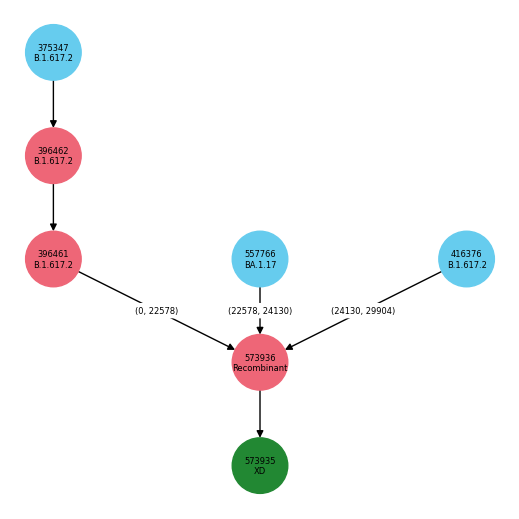

In [16]:
sample_name = 'Turkey/HSGM-F12594/2021'

closest_sample = None
for node in ts.nodes():
    if 'strain' in node.metadata:
        if node.metadata['strain'] == sample_name:
            closest_sample = node.id
            break

G = nx.DiGraph()
related_nodes = [closest_sample]
nodes_to_search = [closest_sample]
labeldict = {}
nodecolours = {}
edgelabels = defaultdict(list)
G.add_node(closest_sample)
nodecolours[closest_sample] = col_green

while nodes_to_search:
    node = ts.node(nodes_to_search.pop(0))
    labeldict[node.id] = str(node.id) + '\n' + node.metadata['Imputed_lineage']
    if (not node.is_sample()) or node.id == closest_sample:
        parent_node = None
        for t in ts.trees():
            if t.parent(node.id) != parent_node:
                parent_node = t.parent(node.id)
                nodes_to_search.append(parent_node)
                related_nodes.append(parent_node)
                if parent_node not in G.nodes:
                    G.add_node(parent_node)
                    nodecolours[parent_node] = col_red
                G.add_edge(parent_node, node.id)
                edge = ts.edge(t.edge(node.id))
                if edge.right - edge.left != 29904:
                    edgelabels[(parent_node, node.id)].append((int(edge.left), int(edge.right)))
    else:
        nodecolours[node.id] = col_blue
        
for key, value in edgelabels.items():
    edgelabels[key] = '\n'.join([str(v) for v in set(value)])

pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
fig = plt.figure(1, figsize=(5, 5))
nx.draw(G, 
        pos=pos, 
        with_labels = True, 
        labels=labeldict, 
        node_color = [nodecolours[node] for node in G.nodes],
        node_size = 1600, 
        font_size = 6)
text = nx.draw_networkx_edge_labels(G,
                                    pos,
                                    edge_labels=edgelabels,
                                    label_pos=0.5,
                                    rotate = False,
                                    font_size=6)

plt.show()